# Bank Transaction Classifier
## Model Selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# Area Under the Precision-Recall Curve 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, auc, average_precision_score

### Import data

In [2]:
%%time

# import training and test data
PATH_train = (r'assets\santander\train_clean.csv')
PATH_test = (r'assets\santander\test_clean.csv')

train_data = pd.read_csv(PATH_train, index_col=0)
test_data = pd.read_csv(PATH_test, index_col=0)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

display(df_train.head())

,target,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,0,-0.030036,0.189206,-0.142440,-0.143565,-0.151003,0.048416,-0.006850,0.524275,-0.027437,...,0.049008,-0.105020,0.121585,-0.095700,-0.204164,-0.001877,-0.050741,0.139615,-0.158355,0.029863
1,0,0.106808,0.214185,0.110886,-0.330231,0.198607,0.066315,-0.007137,0.271827,0.035643,...,0.256393,0.002263,0.338595,-0.165596,0.119298,-0.018020,0.046759,-0.013597,0.114231,0.122277
2,0,0.076225,0.235300,-0.076227,-0.116202,-0.269336,0.047058,0.084512,0.128066,0.001696,...,-0.040279,0.115815,-0.076621,0.107429,-0.189526,-0.000845,-0.062543,-0.073197,-0.077206,0.085458
3,0,0.048793,0.238961,0.462174,-0.136540,0.150583,0.044177,-0.094569,-0.232034,-0.064521,...,0.123483,-0.145394,-0.072105,-0.174420,-0.030363,-0.003602,-0.068549,0.031388,0.084580,0.154636
4,0,0.023979,-0.271960,-0.424338,0.035767,-0.105605,-0.058718,-0.118066,0.027984,0.016761,...,0.035982,0.016627,0.117125,-0.109610,-0.110014,-0.324441,0.008335,0.083176,-0.084813,0.022294


Wall time: 8min 12s


### Reduce memory usage

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 315.68 MB
Memory usage after optimization is: 80.64 MB
Decreased by 74.5%
Memory usage of dataframe is 173.95 MB
Memory usage after optimization is: 44.63 MB
Decreased by 74.3%


In [4]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Train, test, split

In [5]:
#
#data = df_train_raw.drop('target', axis=1)
#target = df_train_raw['target']
#features = [c for c in data.columns]
#
#X_train = data
#y_train = target
#X_test = df_test
#y_test = pd.DataFrame()

In [6]:
#
data = df_train.drop('target', axis=1)
target = df_train['target']
features = [c for c in data.columns]
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

## Logistic Regression

In [7]:
%%time

#
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver='lbfgs', random_state=42)
# Train the classifier
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
# metrics
lr_metrics = {}
lr_metrics['Accuracy score'] = accuracy_score(y_test, y_pred)
lr_metrics['Mean absolute error'] = mean_absolute_error(y_test, y_pred)
lr_metrics['Mean squared error'] = mean_squared_error(y_test, y_pred)

Wall time: 6.88 s


### Confusion matrix

Recall metric in the training dataset: 78.50098619329388%
Precision metric in the training dataset: 78.1615520282187%


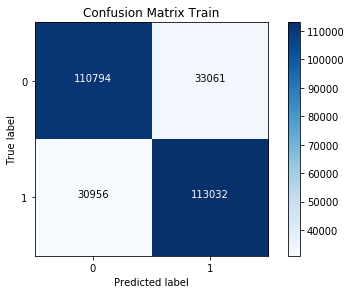

In [8]:
# predict training values
y_pred_train = LR.predict(X_train)
# plot training values
cnf_matrix = confusion_matrix(y_train, y_pred_train)
# display and store metrics
lr_metrics['Train Recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the training dataset: {}%".format(lr_metrics['Train Recall metric'])
     )
lr_metrics['Train Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the training dataset: {}%".format(lr_metrics['Train Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix Train')
plt.savefig('assets\logistic_conf_train.png')
plt.show()

Recall metric in the testing dataset: 78.28423456033859%
Precision metric in the testing dataset: 78.07483624300694%


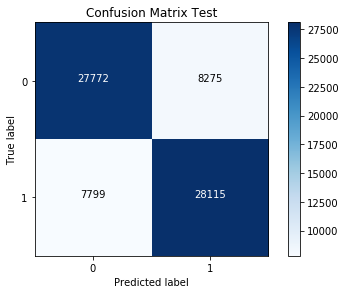

In [9]:
# plot test values
cnf_matrix = confusion_matrix(y_test, y_pred)
# display and store metrics
lr_metrics['Test Recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the testing dataset: {}%".format(lr_metrics['Test Recall metric'])
     )
lr_metrics['Test Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the testing dataset: {}%".format(lr_metrics['Test Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix Test')
plt.savefig('assets\logistic_conf_test.png')
plt.show()

### ROC curve

ROC-AUC: 0.777


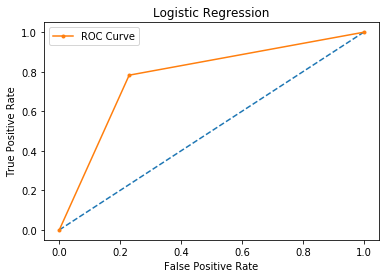

In [10]:
# calculate AUC
lr_metrics['ROC-AUC'] = auc_score = roc_auc_score(y_test, y_pred)
print('ROC-AUC: %.3f' % lr_metrics['ROC-AUC'])
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig('assets\logistic_ROC.png')
plt.show()

### Precision-recall curve

f1=0.778 auc=0.832 ap=0.713


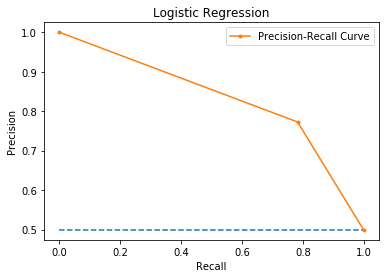

In [11]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
lr_metrics['F1 score'] = f1_score(y_test, y_pred)
# calculate precision-recall AUC
lr_metrics['Precision-Recall AUC'] = auc(recall, precision)
# calculate average precision score
lr_metrics['Average Precision'] = average_precision_score(y_test, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (lr_metrics['F1 score'],
                                    lr_metrics['Precision-Recall AUC'],
                                    lr_metrics['Average Precision']))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('assets\logistic_precision_recall.png')
plt.show()

### Metrics

In [12]:
# view metrics
print('Logistic Regression')
for i in lr_metrics.items():
    print(i)

Logistic Regression
('Accuracy score', 0.776629007378997)
('Mean absolute error', 0.22337099262100304)
('Mean squared error', 0.22337099262100304)
('Train Recall metric', 78.50098619329388)
('Train Precision metric', 78.1615520282187)
('Test Recall metric', 78.28423456033859)
('Test Precision metric', 78.07483624300694)
('ROC-AUC', 0.7766404698305719)
('F1 score', 0.7776886479309582)
('Precision-Recall AUC', 0.8319114290826525)
('Average Precision', 0.7132039955693166)


## Random Forest

In [13]:
#
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=10, random_state=42)
# instantiate Random Forest Classifier
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

# metrics
rfc_metrics = {}
rfc_metrics['Accuracy score'] = accuracy_score(y_test, y_pred)
rfc_metrics['Mean absolute error'] = mean_absolute_error(y_test, y_pred)
rfc_metrics['Mean squared error'] = mean_squared_error(y_test, y_pred)

### Confusion matrix

Recall metric in the training dataset: 99.50065283218046%
Precision metric in the training dataset: 99.50206721746297%


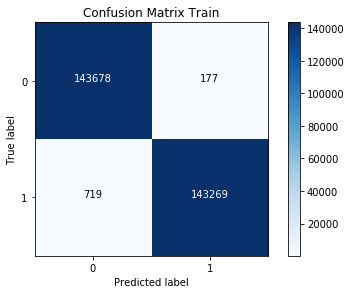

In [15]:
# predict training values
y_pred_train = RFC.predict(X_train)
# plot training values
cnf_matrix = confusion_matrix(y_train, y_pred_train)
# display and store metrics
rfc_metrics['Train Recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the training dataset: {}%".format(rfc_metrics['Train Recall metric'])
     )
rfc_metrics['Train Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the training dataset: {}%".format(rfc_metrics['Train Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix Train')
plt.savefig('assets/random_forest_conf_train.png')
plt.show()

Recall metric in the testing dataset: 87.61485771565407%
Precision metric in the testing dataset: 87.94285869182185%


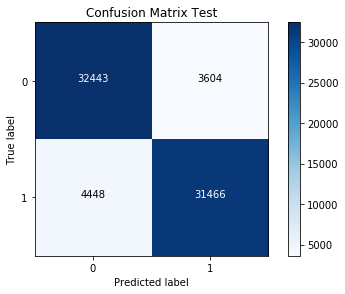

In [16]:
# plot test values
cnf_matrix = confusion_matrix(y_test, y_pred)
# display and store metrics
rfc_metrics['Test Recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the testing dataset: {}%".format(rfc_metrics['Test Recall metric'])
     )
rfc_metrics['Test Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the testing dataset: {}%".format(rfc_metrics['Test Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix Test')
plt.savefig('assets/random_forest_conf_test.png')
plt.show()

### ROC curve

ROC-AUC: 0.888


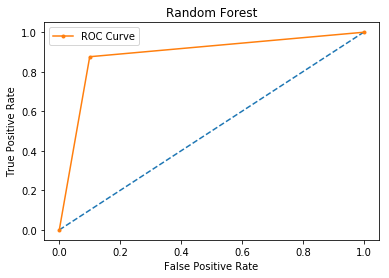

In [17]:
# calculate AUC
rfc_metrics['ROC-AUC'] = auc_score = roc_auc_score(y_test, y_pred)
print('ROC-AUC: %.3f' % rfc_metrics['ROC-AUC'])
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig('assets/random_forest_ROC.png')
plt.show()

### Precision-recall curve

f1=0.887 auc=0.918 ap=0.848


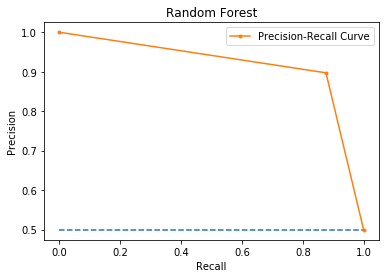

In [18]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
rfc_metrics['F1 score'] = f1_score(y_test, y_pred)
# calculate precision-recall AUC
rfc_metrics['Precision-Recall AUC'] = auc(recall, precision)
# calculate average precision score
rfc_metrics['Average Precision'] = average_precision_score(y_test, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (rfc_metrics['F1 score'],
                                    rfc_metrics['Precision-Recall AUC'],
                                    rfc_metrics['Average Precision']))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('assets/random_forest_precision_recall.png')
plt.show()

### Metrics

In [19]:
# view metrics
print('Random Forest')
for i in rfc_metrics.items():
    print(i)

Random Forest
('Accuracy score', 0.8881060574477843)
('Mean absolute error', 0.11189394255221578)
('Mean squared error', 0.11189394255221578)
('Train Recall metric', 99.50065283218046)
('Train Precision metric', 99.50206721746297)
('Test Recall metric', 87.61485771565407)
('Test Precision metric', 87.94285869182185)
('ROC-AUC', 0.8880839981241408)
('F1 score', 0.8865659867012283)
('Precision-Recall AUC', 0.9175969696275017)
('Average Precision', 0.8479216417907272)


## Light Gradient Boosting

In [20]:
# instantiate Light GBM Classifier
from lightgbm import LGBMClassifier
CLF = LGBMClassifier(random_state=42)
CLF.fit(X_train, y_train)
y_pred = CLF.predict(X_test)
# metrics
lgbm_metrics = {}
lgbm_metrics['Accuracy score'] = accuracy_score(y_test, y_pred)
lgbm_metrics['Mean absolute error'] = mean_absolute_error(y_test, y_pred)
lgbm_metrics['Mean squared error'] = mean_squared_error(y_test, y_pred)

### Confusion matrix

Recall metric in the training dataset: 85.2848848515154%
Precision metric in the training dataset: 85.25108243188684%


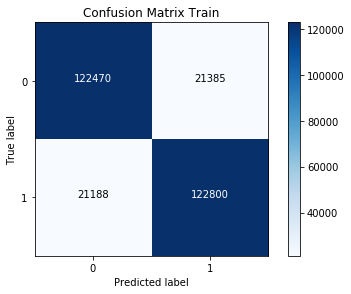

In [21]:
# predict training values
y_pred_train = CLF.predict(X_train)
# plot training values
cnf_matrix = confusion_matrix(y_train, y_pred_train)
# display and store metrics
lgbm_metrics['Train Recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the training dataset: {}%".format(lgbm_metrics['Train Recall metric'])
     )
lgbm_metrics['Train Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the training dataset: {}%".format(lgbm_metrics['Train Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix Train')
plt.savefig('assets\light_gbm_conf_train.png')
plt.show()

Recall metric in the testing dataset: 83.88372222531603%
Precision metric in the testing dataset: 83.898965171915%


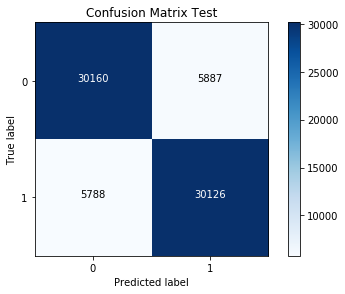

In [22]:
# plot test values
cnf_matrix = confusion_matrix(y_test, y_pred)
# display and store metrics
lgbm_metrics['Test Recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the testing dataset: {}%".format(lgbm_metrics['Test Recall metric'])
     )
lgbm_metrics['Test Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the testing dataset: {}%".format(lgbm_metrics['Test Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix Test')
plt.savefig('assets\light_gbm_conf_test.png')
plt.show()

### ROC curve

ROC-AUC: 0.838


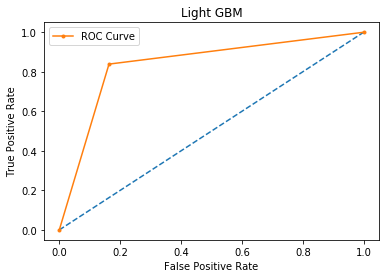

In [23]:
# calculate AUC
lgbm_metrics['ROC-AUC'] = auc_score = roc_auc_score(y_test, y_pred)
print('ROC-AUC: %.3f' % lgbm_metrics['ROC-AUC'])
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Light GBM')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig('assets\light_gbm_ROC.png')
plt.show()

### Precision-recall curve

f1=0.838 auc=0.878 ap=0.782


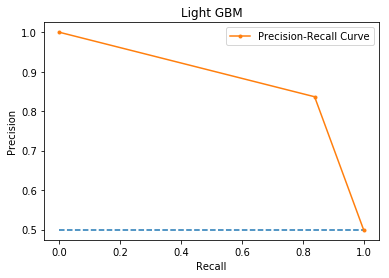

In [24]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
lgbm_metrics['F1 score'] = f1_score(y_test, y_pred)
# calculate precision-recall AUC
lgbm_metrics['Precision-Recall AUC'] = auc(recall, precision)
# calculate average precision score
lgbm_metrics['Average Precision'] = average_precision_score(y_test, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (lgbm_metrics['F1 score'],
                                    lgbm_metrics['Precision-Recall AUC'],
                                    lgbm_metrics['Average Precision']))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Light GBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('assets\light_gbm_precision_recall.png')
plt.show()

### Metrics

In [25]:
# view metrics
print('Light GBM')
for i in lgbm_metrics.items():
    print(i)

Light GBM
('Accuracy score', 0.8377593418657329)
('Mean absolute error', 0.16224065813426716)
('Mean squared error', 0.16224065813426716)
('Train Recall metric', 85.2848848515154)
('Train Precision metric', 85.25108243188684)
('Test Recall metric', 83.88372222531603)
('Test Precision metric', 83.898965171915)
('ROC-AUC', 0.8377613303542552)
('F1 score', 0.837682650465055)
('Precision-Recall AUC', 0.8779004656629318)
('Average Precision', 0.7821460087311239)
